# Retina Blood Vessels Detection

### Notebook's imports

In [1]:
import matplotlib.pyplot as plt
import cv2

# Classic method

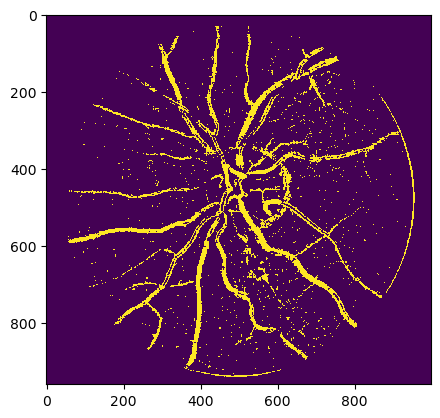

In [2]:
from classifiers.classic import ClassicClassifier
cc = ClassicClassifier([(5, 5), (12, 12), (20, 20)], 200)
image = cv2.imread("../data/CHASED/Image_01L.jpg")
proc_image = cc.process(image)
plt.imshow(proc_image)